### import library

In [1]:
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2 )
library(Matrix)
library(DropletUtils)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

Attaching SeuratObject

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAny

### load data

In [2]:
data.dir = "/work/zeng/yinglu/yao/project/selection/data/homo_intestine/10x"

In [3]:
intestine_data <- Read10X(data.dir = data.dir)

In [4]:
mat_filtered <- as.matrix(intestine_data)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.1 GiB”


In [5]:
dim(mat_filtered)

[1] 19525 14537

In [6]:
if.cluster = FALSE
if(!if.cluster){
        cluster.dir <- file.path(data.dir, "/groups.csv")
        cluster <- read.csv(
        file = cluster.dir,
        as.is = TRUE
        )
}

### Integrate data with CCA method of Seurat

In [7]:
Ileum1 = mat_filtered[, grep("Ileum.1", colnames(mat_filtered))]

In [10]:
cluster_Ileum1 = cluster[grep("Ileum.1", colnames(mat_filtered)),]

In [11]:
cluster_Ileum1_list <- cluster_Ileum1[,2]

In [12]:
P_Ileum1 <- CreateSeuratObject(counts = Ileum1,  min.cells = 3, min.features = 100)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [13]:
for (g in c( "Ileum.2", "Rectum.1", "Rectum.2", "Colon.1", "Colon.2")){
    print(g)
    P_Ileum1 <- NormalizeData(object = P_Ileum1)
    P_Ileum1 <- FindVariableFeatures(object = P_Ileum1)
    P_Ileum1 <- ScaleData(object = P_Ileum1)
    
    Ileum2 = mat_filtered[, grep(g, colnames(mat_filtered))]
    cluster_Ileum2 = cluster[grep(g, colnames(mat_filtered)),]
    P_Ileum2 <- CreateSeuratObject(counts = Ileum2,  min.cells = 3, min.features = 100)
    P_Ileum2 <- NormalizeData(object = P_Ileum2)
    P_Ileum2 <- FindVariableFeatures(object = P_Ileum2)
    P_Ileum2 <- ScaleData(object = P_Ileum2)
    Ileum1_cca <- RunCCA(object1 = P_Ileum1, object2 = P_Ileum2)
    print(dim(Ileum1_cca))
    
    cluster_cca <- c(cluster_Ileum1_list, cluster_Ileum2[,2])
    print(length(cluster_Ileum1_list))
    
    cluster_Ileum1_list <- cluster_cca
    P_Ileum1 <- Ileum1_cca
}


[1] "Ileum.2"


Centering and scaling data matrix

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

Running CCA

Merging objects



[1] 17283  6167
[1] 2745
[1] "Rectum.1"


Centering and scaling data matrix

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

Running CCA

Merging objects



[1] 18649  9009
[1] 6167
[1] "Rectum.2"


Centering and scaling data matrix

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

Running CCA

Merging objects



[1] 18863 10065
[1] 9009
[1] "Colon.1"


Centering and scaling data matrix

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

Running CCA

Merging objects



[1] 19055 11884
[1] 10065
[1] "Colon.2"


Centering and scaling data matrix

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

Running CCA

Merging objects



[1] 19208 14537
[1] 11884


In [14]:
dim(Ileum1_cca)

[1] 19208 14537

In [15]:
length(cluster_Ileum1_list)

[1] 14537

In [16]:
Ileum1_cca <- ScaleData(object = Ileum1_cca)

Centering and scaling data matrix



###  cluster

In [17]:
Ileum1_cca <- FindNeighbors(object = Ileum1_cca, reduction="cca")

Computing nearest neighbor graph

Computing SNN



In [18]:
Ileum1_cca <- FindClusters(Ileum1_cca, resolution = 0.1)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14537
Number of edges: 465603

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9604
Number of communities: 7
Elapsed time: 1 seconds


In [19]:
Ileum1_cca <- RunTSNE(Ileum1_cca,reduction="cca")

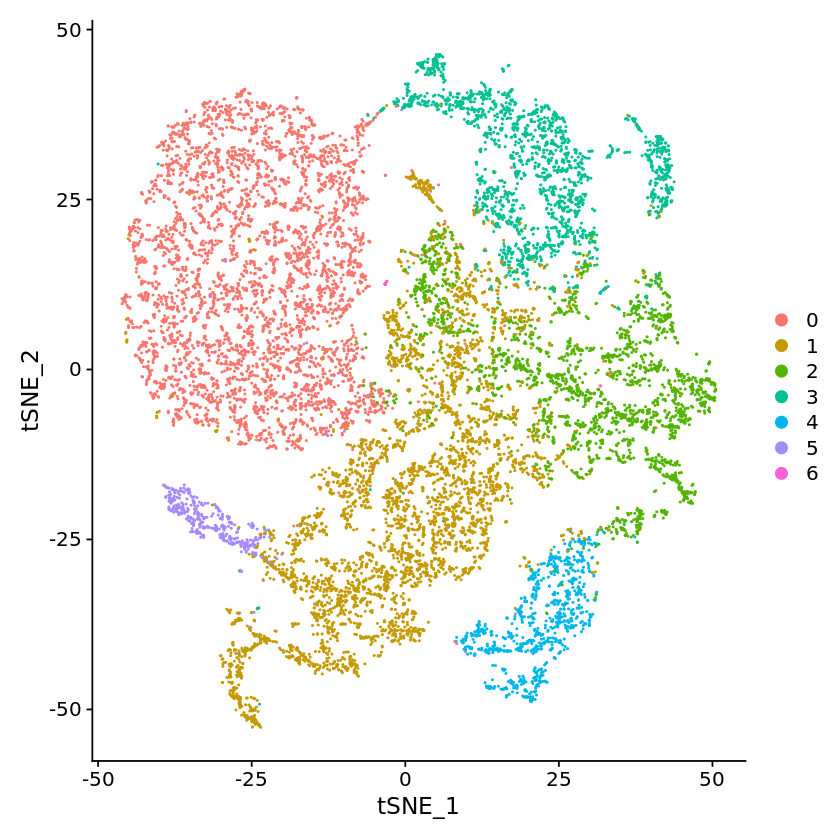

In [20]:
DimPlot(Ileum1_cca, reduction = "tsne",label=FALSE, pt.size=0.2)

### label the cell based on original data

In [21]:
group <- list()
for (i in colnames(Ileum1_cca)) {
    group_name <- strsplit(i, "_")[[1]][3]
    group_name <- strsplit(group_name, "[.]")[[1]]
    if ("Progenitor" %in% group_name){
        ele = "EP"
    }else if ("Enteriendocrine" %in% group_name){
        ele = "Endocrine"
    }else{
        ele = group_name[1]
    }
    
    group <- c(group, ele)
}

In [22]:
Idents(Ileum1_cca) <- group

In [23]:
unique(group)

[[1]]
[1] "Enterocyte"

[[2]]
[1] "Goblet"

[[3]]
[1] "Paneth"

[[4]]
[1] "Endocrine"

[[5]]
[1] "EP"

[[6]]
[1] "TA"

[[7]]
[1] "Stem"

In [24]:
# Specify the color of each group
my_cols <- c('Enterocyte'='#F68282','Goblet'='#31C53F','Paneth'='#005DFF','Endocrine'='#B95FBB',
             'EP'='#D4D915','TA'='#28CECA','Stem'='#ff9a36')

Warning message in eval(quote(list(...)), env):
“NAs introduced by coercion”


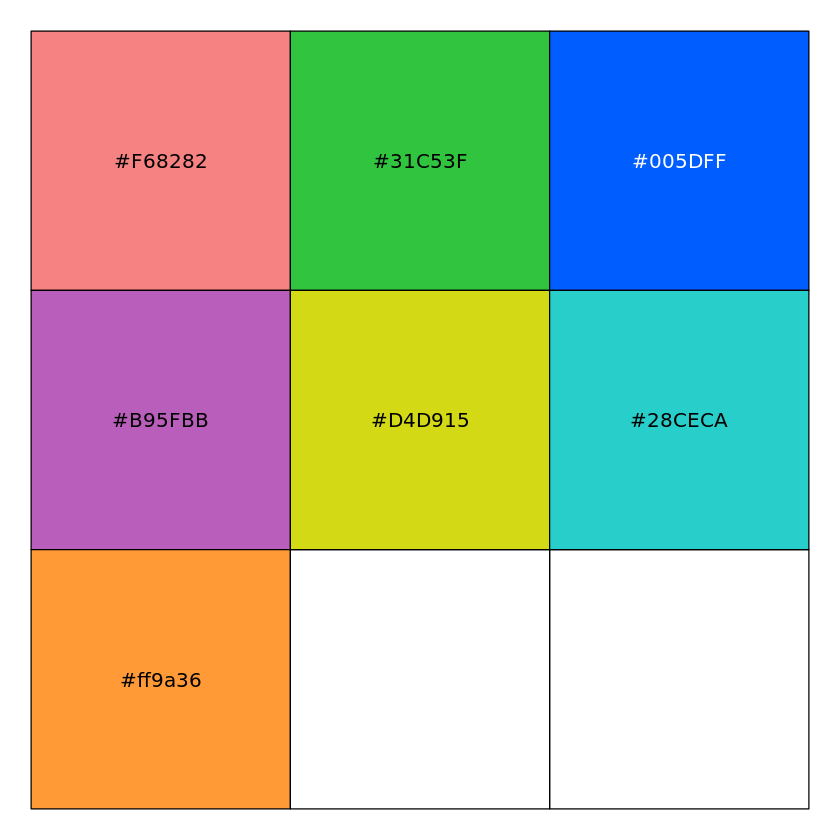

In [27]:
my_cols2 <- my_cols[order(as.integer(names(my_cols)))]
scales::show_col(my_cols2)

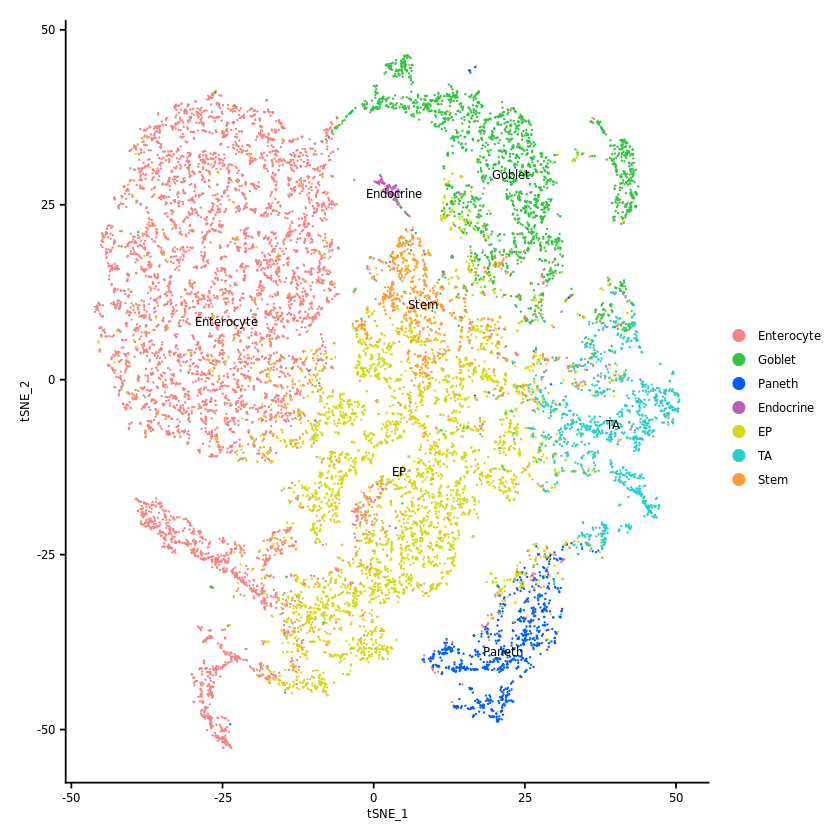

In [28]:
DimPlot(Ileum1_cca, reduction = "tsne",label=TRUE,pt.size=0.02,label.size=7/.pt, sizes.highlight=7/.pt, cols = my_cols2)+ 
theme(axis.text=element_text(size=7),axis.title=element_text(size=7), legend.key.size = unit(0.05, 'in'),legend.text = element_text(size=7), legend.key.height = unit(0.2, 'in'))

In [29]:
ggsave(filename=file.path(data.dir, "/cluster.pdf"),  units = "in", width = 4, height = 3)